In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12,4)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib

In [3]:
import numpy as np
import pandas as pd

In [4]:
DATA_DIR = pathlib.Path("data")

# Loading data

In [5]:
df = pd.read_csv("data/AEP_hourly.csv", parse_dates=["Datetime"], index_col="Datetime")

In [6]:
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


## Fix timestamps

In [7]:
df.index.is_monotonic, df.index.is_unique

(False, False)

In [8]:
df = df.sort_index()
df

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


### New index

In [9]:
new_idx = pd.date_range("2004-10-01 01:00:00", "2018-08-03 00:00:00", freq="1H")

In [10]:
df[~df.index.duplicated(keep='first')]

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
...,...
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0


In [11]:
dfi = df[~df.index.duplicated(keep='first')].reindex(new_idx)

In [12]:
dfi.index.is_monotonic, dfi.index.is_unique, dfi.index.freq

(True, True, <Hour>)

### Missing values

In [13]:
dfi.isnull().mean()

AEP_MW    0.000223
dtype: float64

In [14]:
dfi.ffill(inplace=True)

# DalaModule

In [15]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

In [16]:
class ElectricityDataset(Dataset):
    """Dataset which samples the data from hourly electricity data."""

    def __init__(self, df, samples, hist_len=168, fct_len=24, col="AEP_MW"):
        self.hist_num = hist_len
        self.fct_num = fct_len
        self.hist_len = pd.Timedelta(hours=hist_len)
        self.fct_len = pd.Timedelta(hours=fct_len)
        self.offset = pd.Timedelta(hours=1)

        self.max_ts = df.index.max() - self.hist_len - self.fct_len + self.offset
        self.raw_data = df

        assert samples <= self.raw_data[:self.max_ts].shape[0]
        self.samples = samples
        self.col = col
        self.sample()

    def sample(self):
        """Sample individual series as needed."""
        
        self.sample_idx = (self
                           .raw_data[:self.max_ts]
                           .index
                           .to_series()
                           .sample(self.samples, replace=False)
                           .index)

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        start_ts = self.sample_idx[idx]

        hs, he = start_ts, start_ts + self.hist_len - self.offset
        fs, fe = he + self.offset, he + self.fct_len

        hist_data = self.raw_data[hs:].iloc[:self.hist_num]
        fct_data = self.raw_data[fs:].iloc[:self.fct_num]

        return (torch.Tensor(hist_data[self.col].values),
                torch.Tensor(fct_data[self.col].values))

In [58]:
ds = ElectricityDataset(dfi, 10)

In [59]:
start_ts = ds.sample_idx[4]

In [60]:
dfi[start_ts:].head()

,AEP_MW
2016-11-13 23:00:00,13482.0
2016-11-14 00:00:00,13166.0
2016-11-14 01:00:00,12917.0
2016-11-14 02:00:00,12933.0
2016-11-14 03:00:00,12978.0


In [61]:
dfi[start_ts+pd.Timedelta(days=7):].head()

,AEP_MW
2016-11-20 23:00:00,14860.0
2016-11-21 00:00:00,14291.0
2016-11-21 01:00:00,14023.0
2016-11-21 02:00:00,13790.0
2016-11-21 03:00:00,13902.0


In [62]:
ds[4]

(tensor([13482., 13166., 12917., 12933., 12978., 13149., 13566., 14627., 16178.,
         16621., 16436., 15995., 15588., 15040., 14720., 14543., 14355., 14112.,
         14299., 14976., 15408., 15385., 15326., 14891., 14168., 13351., 13145.,
         13066., 13032., 13239., 13702., 14495., 16042., 16502., 16019., 15597.,
         15137., 14698., 14380., 14185., 13985., 13834., 14037., 14827., 15012.,
         14954., 14906., 14390., 13710., 13009., 12576., 12392., 12276., 12274.,
         12852., 13883., 15226., 15665., 15336., 15038., 14763., 14437., 14176.,
         14097., 13991., 13648., 13789., 14469., 14838., 14772., 14732., 14303.,
         13681., 12953., 12560., 12505., 12496., 12570., 13007., 13974., 15402.,
         15929., 15637., 15136., 14734., 14258., 14056., 13885., 13652., 13527.,
         13576., 14316., 14561., 14433., 14319., 13851., 13089., 12361., 12025.,
         11765., 11780., 11913., 12369., 13039., 14541., 15004., 14970., 14531.,
         13929., 14164., 140

In [54]:
dfi.head()

,AEP_MW
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0


In [55]:
dfi.tail()

,AEP_MW
2018-08-02 20:00:00,17673.0
2018-08-02 21:00:00,17303.0
2018-08-02 22:00:00,17001.0
2018-08-02 23:00:00,15964.0
2018-08-03 00:00:00,14809.0


In [22]:
class ElectricityDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self, df,
                 train_range=("2004", "2015"),
                 val_range=("2016","2017"),
                 test_range=("2018", None),
                 factor=0.5,
                 batch_size=64,
                 workers=3):

        super().__init__()
        self.raw_data = df
        self.train_range = train_range
        self.val_range = val_range
        self.test_range = test_range
        self.factor = factor
        self.batch_size = batch_size
        self.workers = workers

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = self.raw_data[slice(*self.train_range)]
            val_df = self.raw_data[slice(*self.val_range)]

            self.train_ds = ElectricityDataset(train_df,
                                               samples=int(self.factor * train_df.shape[0]))
            self.val_ds = ElectricityDataset(val_df,
                                             samples=int(self.factor * val_df.shape[0]))

        if stage == "test" or stage is None:
            test_df = self.raw_data[slice(*self.test_range)]
            self.test_ds = ElectricityDataset(test_df,
                                              samples=int(self.factor * test_df.shape[0]))

    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers)

# Encoder network

In [23]:
class ElectricityEncoder(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, num_layers=1, hidden_units=8):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units

        self.encoder = nn.LSTM(input_size=1,
                               hidden_size=self.hidden_units,
                               num_layers=self.num_layers,
                               batch_first=True)

    def forward(self, x):
        output, (henc, cenc) = self.encoder(x.view(x.shape[0], x.shape[1], 1))
        
        return output, henc, cenc

In [56]:
encoder = ElectricityEncoder()

In [64]:
ds[3]

(tensor([16327., 15915., 15005., 14160., 13477., 13048., 12969., 12888., 13253.,
         14146., 15709., 16456., 16223., 16077., 15902., 15520., 15275., 15109.,
         14865., 14537., 14693., 15565., 15853., 15805., 15770., 15477., 14928.,
         14178., 13645., 13401., 13232., 13177., 13344., 13796., 14231., 14785.,
         15306., 15336., 15030., 14535., 13970., 13533., 13253., 13072., 13354.,
         14330., 14845., 14902., 14862., 14674., 14259., 13599., 13127., 13002.,
         12942., 13026., 13151., 13514., 13997., 14509., 14950., 14820., 14393.,
         14011., 13821., 13579., 13404., 13430., 13747., 14880., 15319., 15271.,
         15210., 14825., 14168., 13463., 12950., 12673., 12608., 12658., 12971.,
         13797., 15394., 16285., 16224., 16514., 16486., 16165., 16085., 15959.,
         15738., 15536., 15731., 16480., 16692., 16529., 16304., 15791., 14889.,
         13937., 13240., 12868., 12669., 12730., 12924., 13687., 15076., 15778.,
         15792., 15901., 157

In [63]:
hist_sample = torch.cat([ds[3][0].unsqueeze(0),
                         ds[5][0].unsqueeze(0)])

fct_sample = torch.cat([ds[3][1].unsqueeze(0),
                        ds[5][1].unsqueeze(0)])

output, hc, cc = encoder(hist_sample)

In [65]:
hist_sample.shape

torch.Size([2, 168])

In [66]:
hc.shape

torch.Size([1, 2, 8])

In [67]:
output.shape

torch.Size([2, 168, 8])

In [68]:
cc.shape

torch.Size([1, 2, 8])

# Decoder network

In [30]:
class ElectricityDecoder(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, num_layers=1, hidden_units=8):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units

        self.decoder = nn.LSTM(input_size=1,
                               hidden_size=self.hidden_units,
                               num_layers=self.num_layers,
                               batch_first=True)
        self.linear = nn.Linear(self.hidden_units, 1)

    def forward(self, x, hidden):
        output, (hc, cc) = self.decoder(x.view(x.shape[0], x.shape[1], 1), hidden)
        output = self.linear(output.squeeze(1))
        return output, hc, cc

In [69]:
decoder = ElectricityDecoder()

In [70]:
a, b, c = decoder(hist_sample[:, [-1]], (hc, cc))

In [71]:
decoder(a, (b, c))

(tensor([[0.2406],
         [0.2406]], grad_fn=<AddmmBackward>),
 tensor([[[ 0.2685, -0.2552, -0.1629, -0.0399,  0.2303,  0.0136,  0.1294,
           -0.0665],
          [ 0.2685, -0.2552, -0.1629, -0.0399,  0.2303,  0.0136,  0.1294,
           -0.0665]]], grad_fn=<StackBackward>),
 tensor([[[ 0.7838, -0.5036, -0.2745, -0.0724,  0.3734,  0.0320,  0.2896,
           -0.1351],
          [ 0.7838, -0.5036, -0.2745, -0.0724,  0.3734,  0.0320,  0.2896,
           -0.1351]]], grad_fn=<StackBackward>))

In [34]:
a.shape

torch.Size([2, 1])

# Encoder-decoder model

In [35]:
class ElectricityModel(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, hist_len=168, fct_len=24, num_layers=1, hidden_units=8, lr=1e-3):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.lr = lr

        self.encoder = ElectricityEncoder(hist_len, fct_len, num_layers, hidden_units)
        self.decoder = ElectricityDecoder(hist_len, fct_len, num_layers, hidden_units)

    def forward(self, x):
        forecasts = []
        enc, hh, cc = self.encoder(x)
        enc = x[:, [-1]]

        for i in range(self.fct_len):
            enc, hc, cc = self.decoder(enc, (hh, cc))
            forecasts.append(enc)
        forecasts = torch.cat(forecasts, dim=1)
        return forecasts

    def training_step(self, batch, batch_idx):
        x, y = batch
        fct = self(x)
        return F.mse_loss(fct, y)

    def validation_step(self, batch, batch_idx):

        x, y = batch
        logits = self(x)
        loss = F.mse_loss(logits, y)
        self.log('val_mse', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

# Scaling

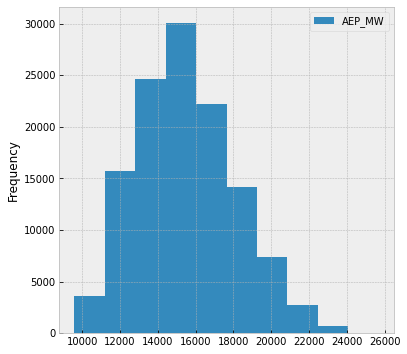

In [36]:
plt.figure(figsize=(6,6))
dfi.plot(kind="hist", ax=plt.gca())

In [37]:
LIMH, LIML =26e3, 9e3

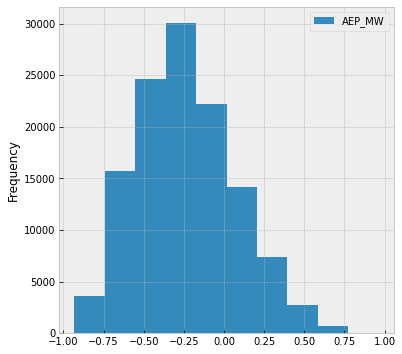

In [38]:
plt.figure(figsize=(6,6))
((2 * dfi - LIML - LIMH) / (LIMH - LIML)).plot(kind="hist", ax=plt.gca())

In [40]:
dfs = (2 * dfi - LIML - LIMH) / (LIMH - LIML)

ds = ElectricityDataModule(dfs, batch_size=32)
model = ElectricityModel(lr=1e-3, hidden_units=64)
trainer = pl.Trainer(max_epochs=20, progress_bar_refresh_rate=1)
trainer.fit(model, ds)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | ElectricityEncoder | 17.2 K
1 | decoder | ElectricityDecoder | 17.2 K
-----------------------------------------------
34.4 K    Trainable params
0         Non-trainable params
34.4 K    Total params
0.137     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [41]:
hist_sample_scaled = (2 * hist_sample - LIML - LIMH) / (LIMH - LIML)

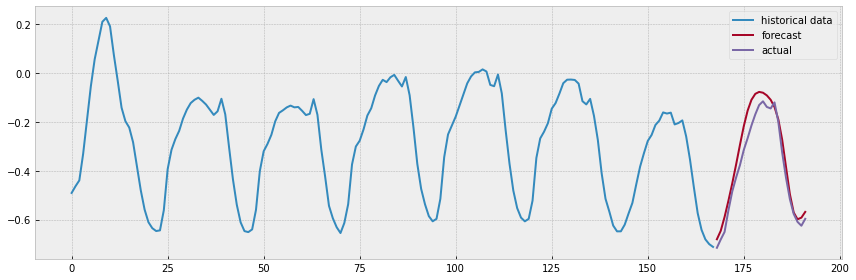

In [42]:
plt.plot((( 2 * hist_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[0], label="historical data")
plt.plot(np.arange(168, 192, 1), model(hist_sample_scaled).detach().numpy()[0], label="forecast")
plt.plot(np.arange(168, 192, 1), (( 2 * fct_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[0], label="actual")

plt.legend(loc=0)
plt.tight_layout()

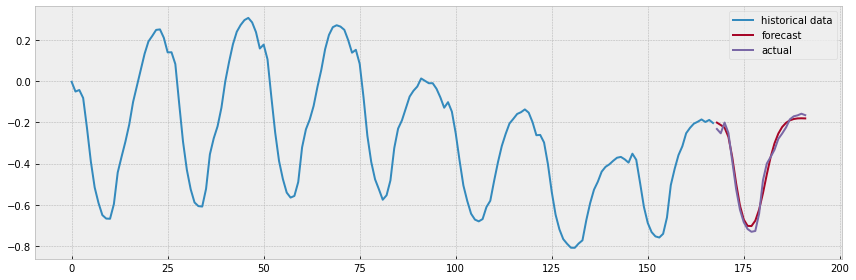

In [43]:
plt.plot((( 2 * hist_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[1], label="historical data")
plt.plot(np.arange(168, 192, 1), model(hist_sample_scaled).detach().numpy()[1], label="forecast")
plt.plot(np.arange(168, 192, 1), (( 2 * fct_sample.numpy() - LIML - LIMH) / (LIMH - LIML))[1], label="actual")

plt.legend(loc=0)
plt.tight_layout()

In [46]:
dl = ds.val_dataloader()

In [48]:
for x in dl:
    fct = model(x[0])
    break

In [52]:
x

[tensor([[-4.0918e-01, -3.5376e-01, -3.9765e-01,  ..., -4.5165e-01,
          -4.5612e-01, -4.6518e-01],
         [ 5.0365e-01,  4.7918e-01,  4.6071e-01,  ..., -1.7318e-01,
          -8.1294e-02,  7.0588e-04],
         [-2.1294e-01, -2.5282e-01, -2.8318e-01,  ...,  5.4118e-03,
          -8.0706e-02, -1.5388e-01],
         ...,
         [-7.8294e-01, -7.8718e-01, -7.8224e-01,  ..., -6.2988e-01,
          -6.8671e-01, -7.2859e-01],
         [-4.3200e-01, -3.9035e-01, -4.0129e-01,  ..., -5.6788e-01,
          -4.8953e-01, -4.6518e-01],
         [-2.2859e-01, -2.4471e-01, -2.6388e-01,  ..., -1.6000e-01,
          -2.0647e-01, -2.4835e-01]]),
 tensor([[-0.4978, -0.4241, -0.4325, -0.5407, -0.6446, -0.7239, -0.7504, -0.7627,
          -0.7649, -0.7346, -0.6454, -0.5021, -0.4428, -0.4301, -0.4199, -0.4151,
          -0.4284, -0.4258, -0.4191, -0.4414, -0.4447, -0.4491, -0.4505, -0.4671],
         [ 0.0559,  0.0864,  0.0531, -0.0194, -0.0255, -0.1293, -0.2988, -0.4487,
          -0.5482, -0.618

In [49]:
fct = fct.detach().numpy()

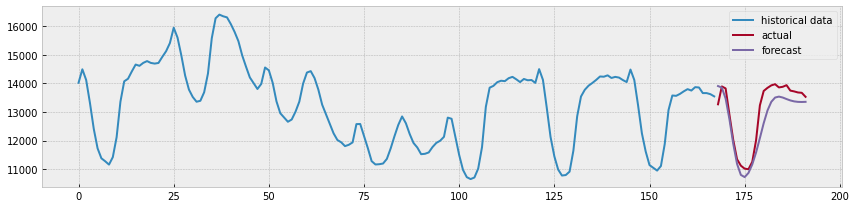

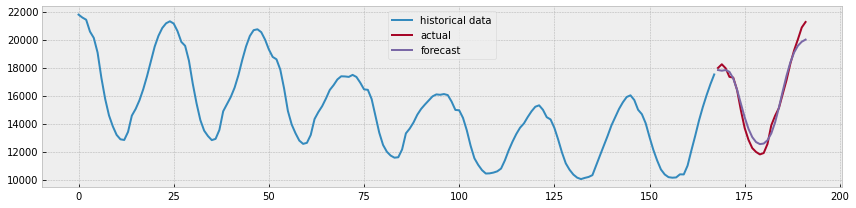

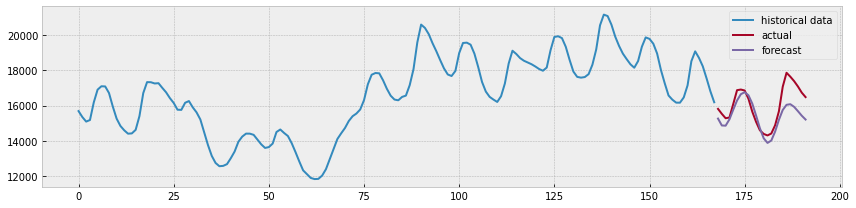

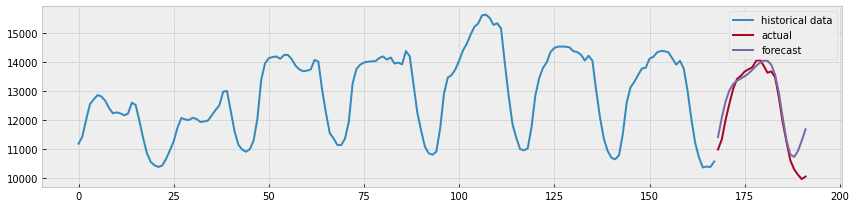

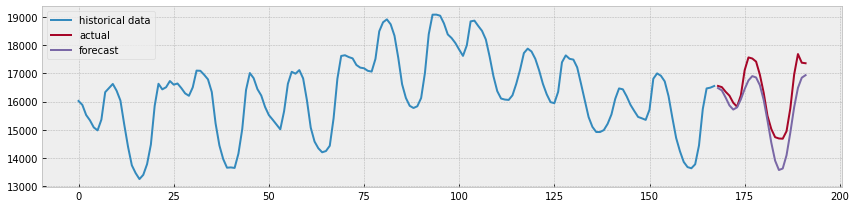

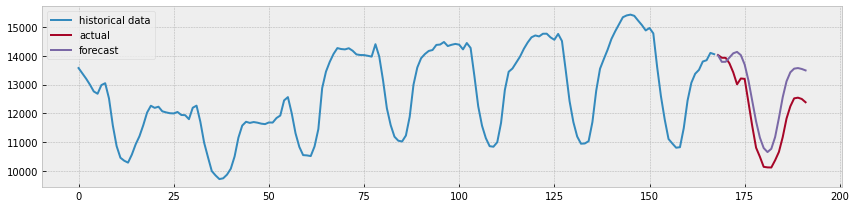

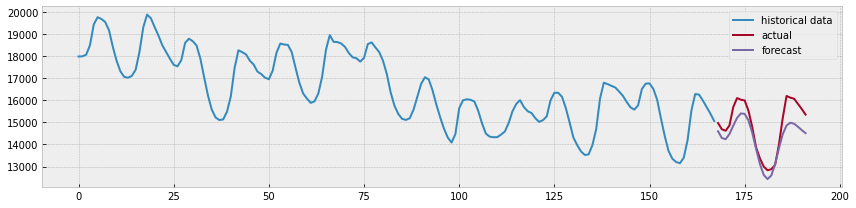

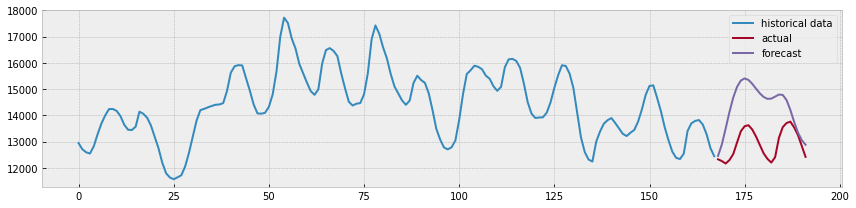

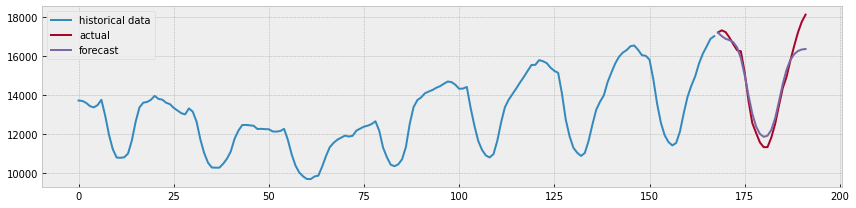

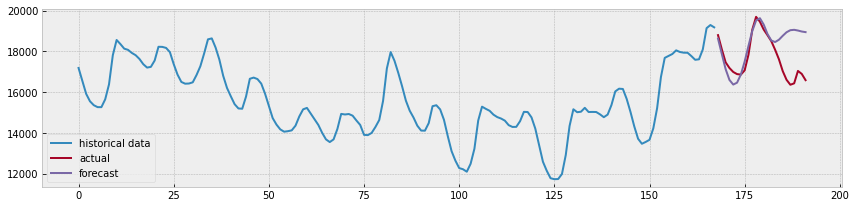

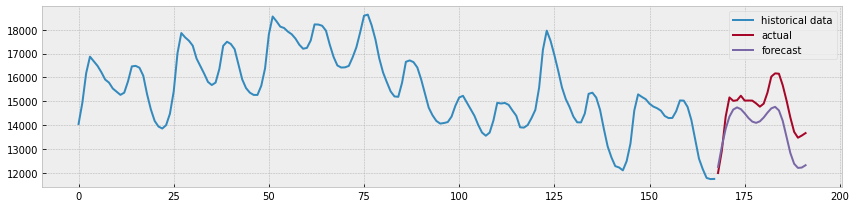

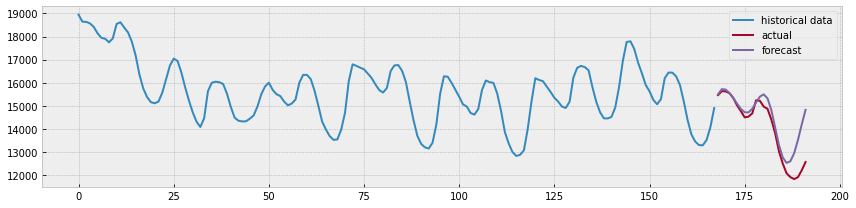

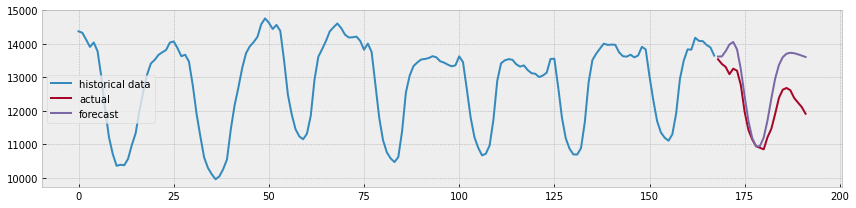

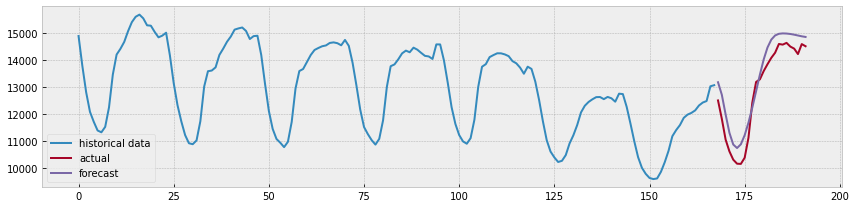

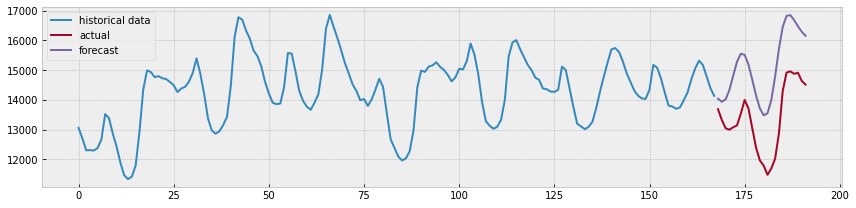

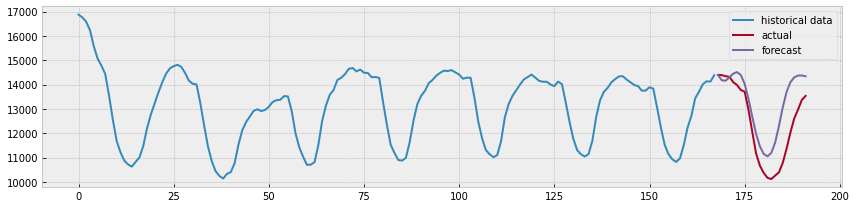

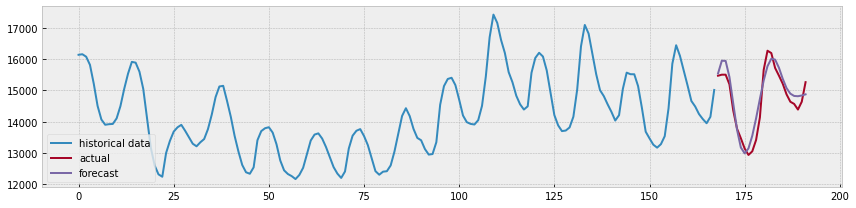

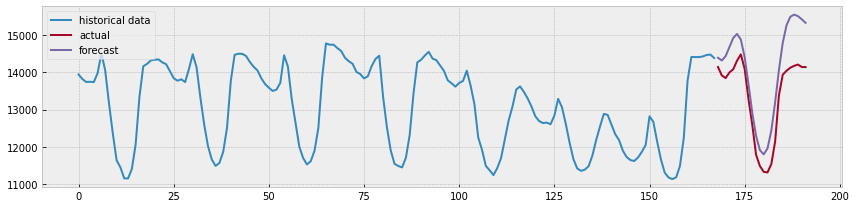

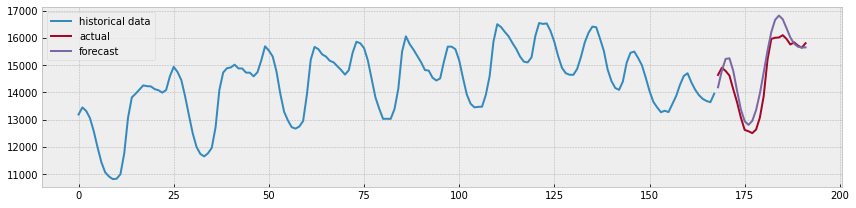

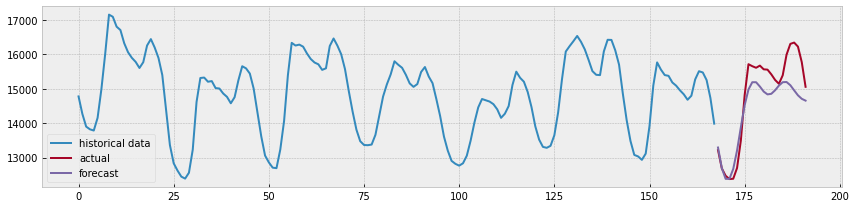

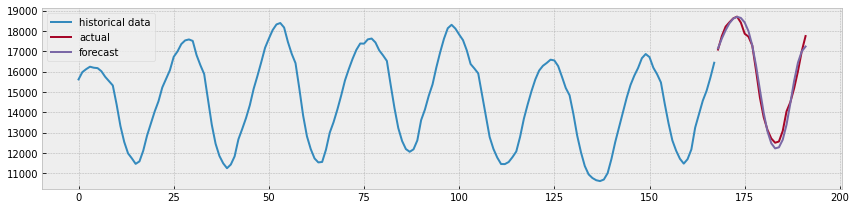

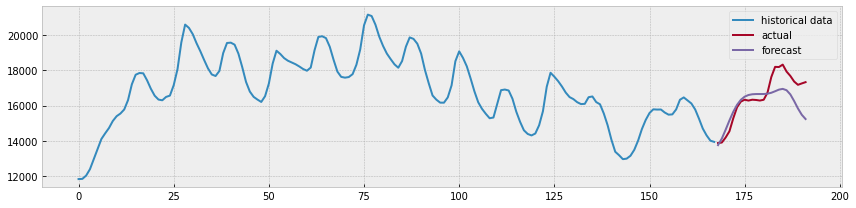

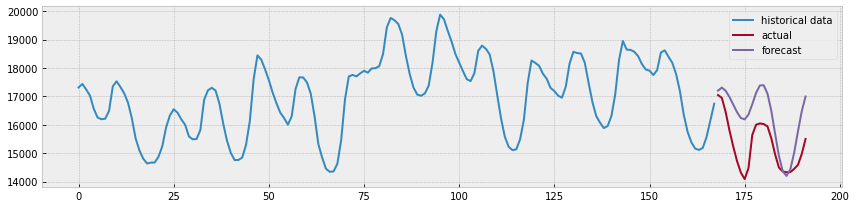

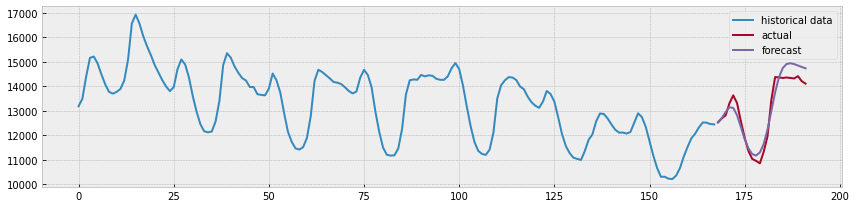

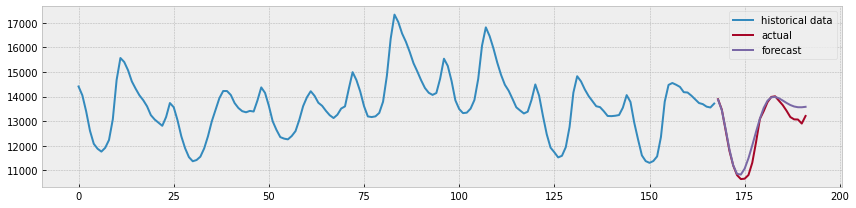

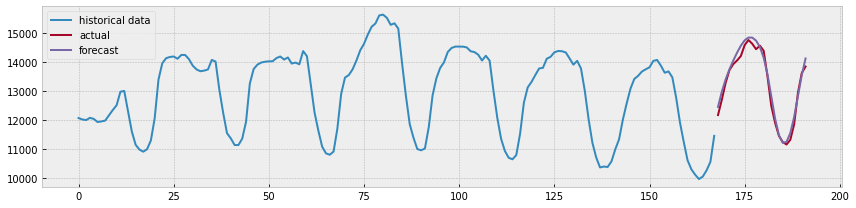

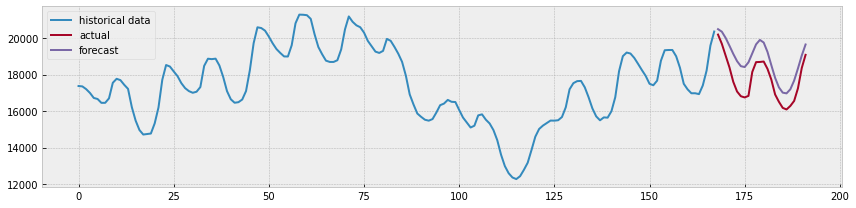

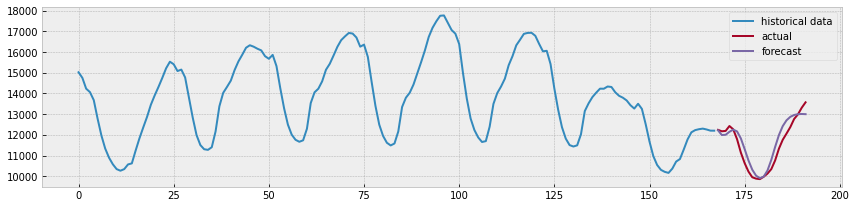

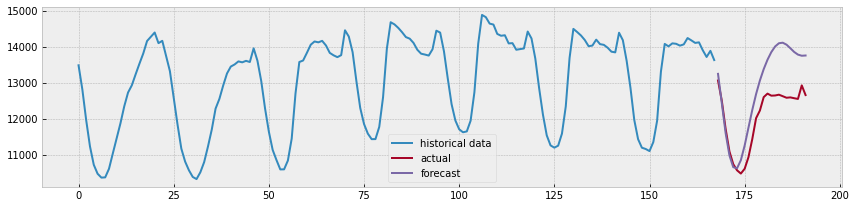

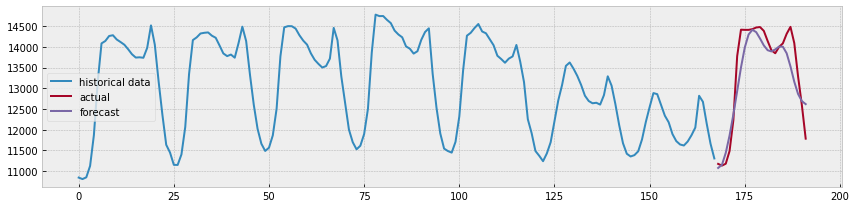

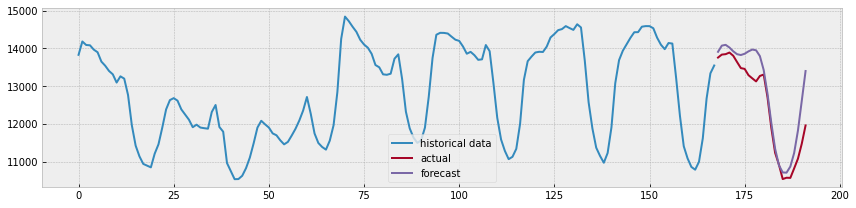

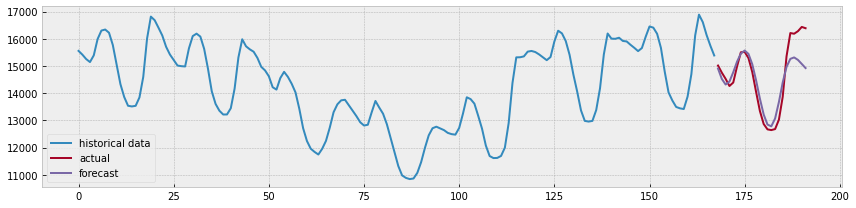

In [53]:
for stream in range(32):
    plt.figure(figsize=(12,3))
    plt.plot((x[0][stream] * (LIMH - LIML) + (LIMH + LIML)) / 2, label="historical data")
    plt.plot(np.arange(168, 192, 1), (x[1][stream] * (LIMH - LIML) + (LIMH + LIML)) / 2, label="actual")
    plt.plot(np.arange(168, 192, 1), (fct[stream] * (LIMH - LIML) + (LIMH + LIML)) / 2, label="forecast")
    plt.legend(loc=0)
    plt.tight_layout()
    plt.show()